##### Suggestion
Best to run all python scripts in different notebooks otherwise variables can interfere

# Comparison Between set temperature and measured temperature

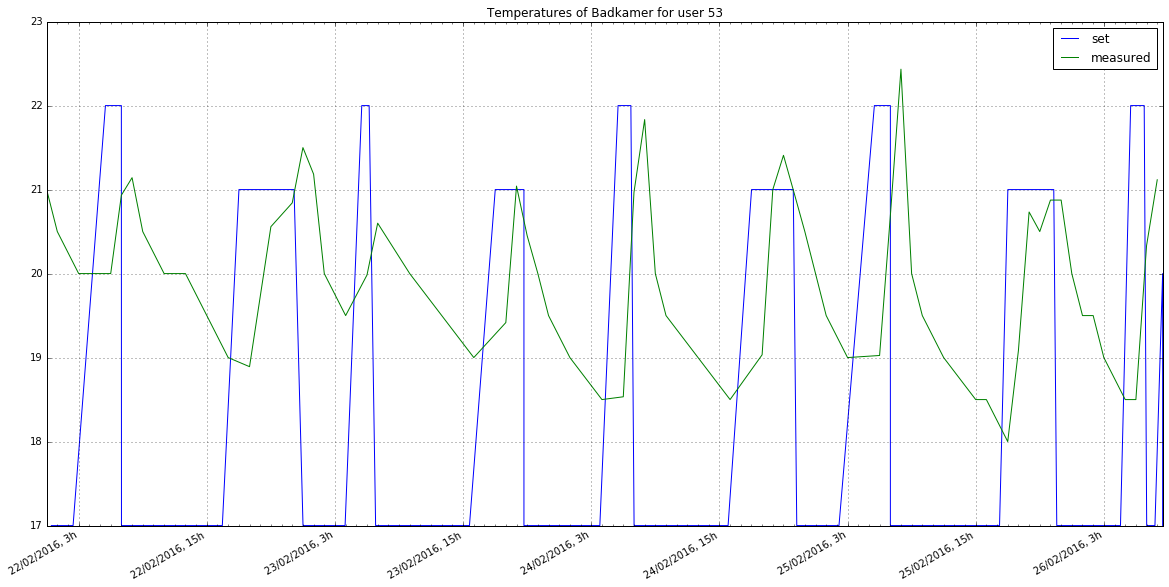

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

user_box = widgets.Text("userid")
display(user_box)
location_box = widgets.Text("Location")
display(location_box)

userId = 0
locationName = ""

def handle_user_submit(sender):
    global userId
    userId = user_box.value
    clear_output()
    print "Getting distinct locations for user " + str(userId)
    show_distinct_locations_for_user(userId)
    
user_box.on_submit(handle_user_submit)

def show_distinct_locations_for_user(userId):
    distinct_locations_user = sqlContext.sql(
        "select distinct l.name "
        + "from locations l "
        + "join outputs o on l.id = o.locationId "
        + "join types t on t.id = o.typeId "
        + "where l.userId = '" + str(userId) + "' "
        + "and t.name = 'THERMO'"
        + "order by l.name")
    
    clear_output()   
    
    for element in distinct_locations_user.collect():
        print element.name

def handle_location_submit(sender):
    global locationName
    locationName = location_box.value
    clear_output()
    print "Computing plot"
    compute_plot_1()
    
location_box.on_submit(handle_location_submit)

def compute_plot_1():
    set_temps = sqlContext.sql(
        "select time, value "
        + "from setTemps "
        + "where Userid = '" + str(userId) + "' "
        + "and locationname = '" + locationName + "' "
        + "and time > '2016-02-22' "
        + "order by time")

    measured_temps = sqlContext.sql(
        "select time, value "
        + "from measuredTemps "
        + "where Userid = '" + str(userId) + "' "
        + "and locationname = '" + locationName + "' "
        + "and time > '2016-02-22' "
        + "order by time")
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(set_temps.select('time').collect(), 
             set_temps.select('value').collect(),
             label = "set")
    plt.plot(measured_temps.select('time').collect(), 
             measured_temps.select('value').collect(),
            label = "measured")
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y, %-Hh'))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    fig.autofmt_xdate()
    
    # force y to 0
    # ax.set_ylim(ymin=0)
    
    plt.title("Temperatures of " + locationName + " for user " + str(userId))
    plt.legend()
    plt.grid()
    
    clear_output() 
    
    plt.show()

##### Optimalization suggestion
For performance gain set_temps and measured_temps in hive table --> Done

# All measured temperatures for user at specific location

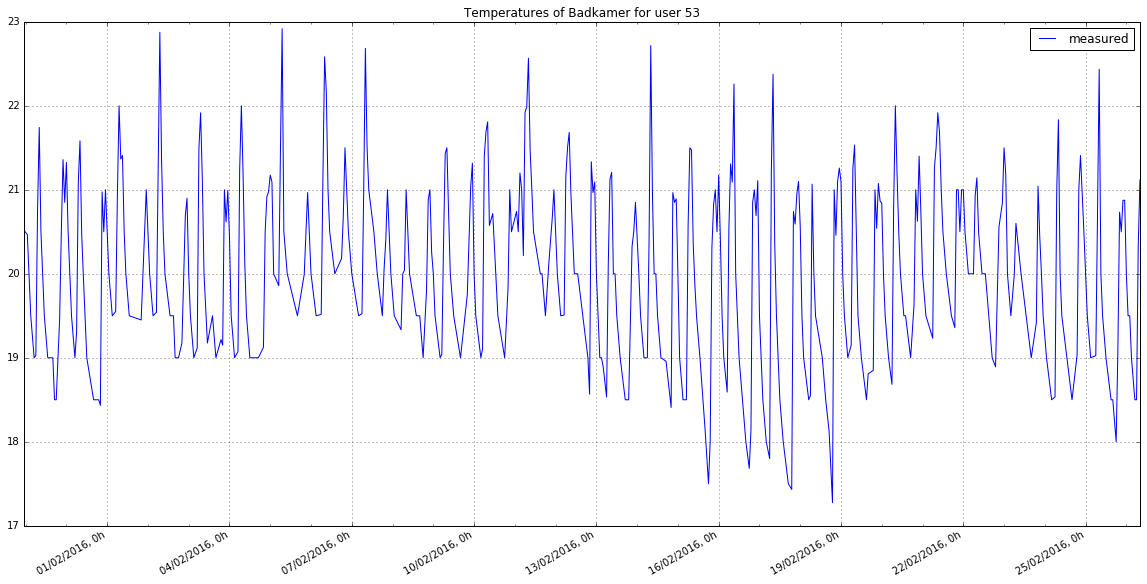

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

user_box = widgets.Text("userid")
display(user_box)
location_box = widgets.Text("Location")
display(location_box)

userId = 0
locationName = ""

def handle_user_submit(sender):
    global userId
    userId = user_box.value
    clear_output()
    print "Getting distinct locations for user " + str(userId)
    show_distinct_locations_for_user(userId)
    
user_box.on_submit(handle_user_submit)

def show_distinct_locations_for_user(userId):
    distinct_locations_user = sqlContext.sql(
        "select distinct l.name "
        + "from locations l "
        + "join outputs o on l.id = o.locationId "
        + "join types t on t.id = o.typeId "
        + "where l.userId = '" + str(userId) + "' "
        + "and t.name = 'THERMO'"
        + "order by l.name")
    
    clear_output()
    
    for element in distinct_locations_user.collect():
        print element.name

def handle_location_submit(sender):
    global locationName
    locationName = location_box.value
    clear_output()
    print "Computing plot"
    compute_plot_2()
    
location_box.on_submit(handle_location_submit)

def compute_plot_2():
    measured_temps = sqlContext.sql(
        "select time, value "
        + "from measuredTemps "
        + "where Userid = '" + str(userId) + "' "
        + "and locationname = '" + locationName + "' "
        + "order by time")
    
    fig, ax = plt.subplots(figsize=(20,10))
    
    plt.plot(measured_temps.select('time').collect(), 
             measured_temps.select('value').collect(),
            label = "measured")
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y, %-Hh'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    fig.autofmt_xdate()
    
    # force y to 0
    # ax.set_ylim(ymin=0)
    
    plt.title("Temperatures of " + locationName + " for user " + str(userId))
    plt.legend()
    plt.grid()
    
    clear_output() 
    
    plt.show()

# Averages for user

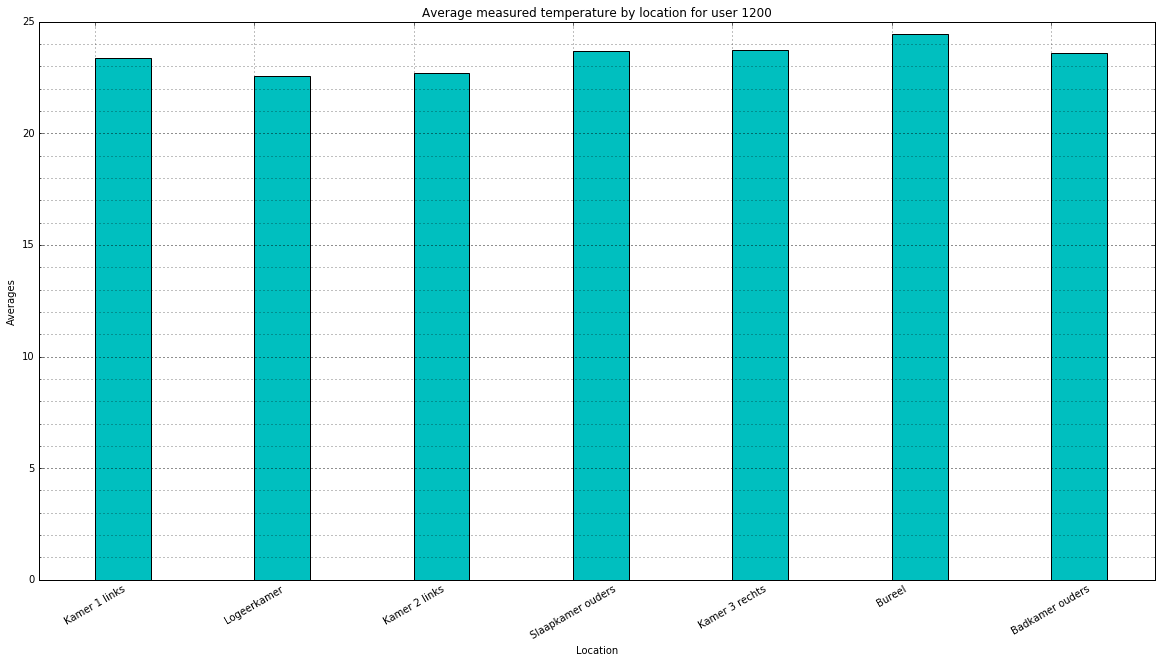

In [79]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np

user = 1200

df = sqlContext.sql(
    "select locationName as name, AVG(value) as average "
    + "from measuredTemps "
    + "where userid = '" + str(user) + "' "
    + "group by locationname")

collected = df.collect()

locations = []
averages = []

for element in collected:
    locations.append(element.name)
    averages.append(element.average)
    
ind = range(len(collected))
width = 0.35

fig, ax = plt.subplots(figsize=(20,10))

plt.bar(ind, averages, width, color='c')

plt.ylabel('Averages')
plt.xlabel('Location')
plt.title('Average measured temperature by location for user ' + str(user))
plt.xticks(ind, locations, rotation=30)
plt.grid(which='major')
plt.grid(which='minor')

ax.yaxis.set_minor_locator(mticker.MultipleLocator())

# Set a buffer around the edge
plt.xlim([min(ind)-width, max(ind)-width])

plt.show()